## Prelim Notebook coding K-Means Clustering from scratch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn import datasets

## A bunch of helper functions

### For actually doing K-Means

In [2]:
# TO DO: what to do when a cluster has no points (I think that's what happens if you have NaN in the centroids)
# Given the data (X) and the current cluster assignments (labels), update centroids by avg'ing points in each cluster
def get_centroids(X, labels):
    centroids = []
    for k in range(len(np.unique(labels))):
        centroids.append(np.mean(X[labels == k], axis=0))
    return np.array(centroids)

# Given the data (X) and current centroids, assign each observation to a new cluster based on the closest centroid
def assign_clusters(X, centroids):
    return np.array([np.argmin(np.sqrt(np.sum((X[j] - centroids) ** 2, axis = 1))) for j in range(len(X))])

# To perform the entire K-Means loop, get both the clusters for each point (labels) and the centroids
def my_K_Means(X, K, tol):
    
    # initialize centroids randomly
    centroids = X[np.random.choice(len(X), K)]
    
    # initialize "previous" centroids to loop
    old = 99999 * np.ones(np.shape(centroids))
    
    # keep iterating while current centroids different enough from previous centroids (from last iteration)
    while np.linalg.norm(centroids-old) > tol:
        
        # copy current centroids as last iteration's before updating
        old = centroids
        
        # assign each point to cluster
        labels = assign_clusters(X, centroids)
    
        # update centroids
        centroids = get_centroids(X, labels)
    return labels, centroids

### For support in determining an appropriate value for K

In [3]:
# Calculate inertia (sum of squared errors of each pt to its cluster centroid) for the resulting clusters
def sse(X, labels, centroids):
    
    # get number of clusters
    k = len(np.unique(labels))
    
    # squared errors for each cluster
    cses = []
    
    for j in range(k):
        
        # for each cluster, get error coordinates for each point is to its centroid
        errors = X[labels == j] - centroids[j]
        
        # square the errors and sum to get the squared error (magnitude) for each point
        errors_sq = errors ** 2
        error_mag_sq = np.sum(errors_sq, axis = 1)
        
        # now get total squared error for the cluster
        cses.append(np.sum(error_mag_sq))
    
    # return sum of squared error over all clusters
    return sum(cses)

# Calculate silhouette coefficient (how 'coherent' the clusters are) for the resulting clusters
def silhouette(X, labels):
    
    # coefficients for each point
    sil = []

    for j in range(len(X)):
        
        # for each point get the average distance to each other point in its cluster
        a = np.sum(np.sqrt(np.sum((X[j] - X[labels == labels[j]]) ** 2, axis=1))) / (len(X[labels == labels[j]]) - 1)

        # also get average distance to each other cluster (distance to each point in each given cluster)
        # get the cluster with minimum average distance to the point
        intra_dists = []
        for k in np.unique(labels):
            if labels[j] != k:
                intra_dists.append(np.mean(np.sqrt(np.sum((X[j] - X[labels == k]) ** 2, axis=1))))
        b = min(intra_dists)
        
        # calculate this point's silhouette coefficient
        sil.append((b-a) / max(a,b))
    
    # return the average coefficient over all points
    return np.mean(sil)

## Now, an illustrative example using the Iris dataset

In [4]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

Let's start out by trying to determine an appropriate value of K, performing K-Means clustering on the data for a range of potential Ks and looking at the inertia (Elbow Method) and silhouette coefficients.

In [5]:
np.random.seed(1)
sils = []
sses = []

for k in range(2,10):
    labels, centroids = my_K_Means(X, k, .0001)
    sils.append(silhouette(X, labels))
    sses.append(sse(X, labels, centroids))

Text(0, 0.5, 'Silhouette coefficient')

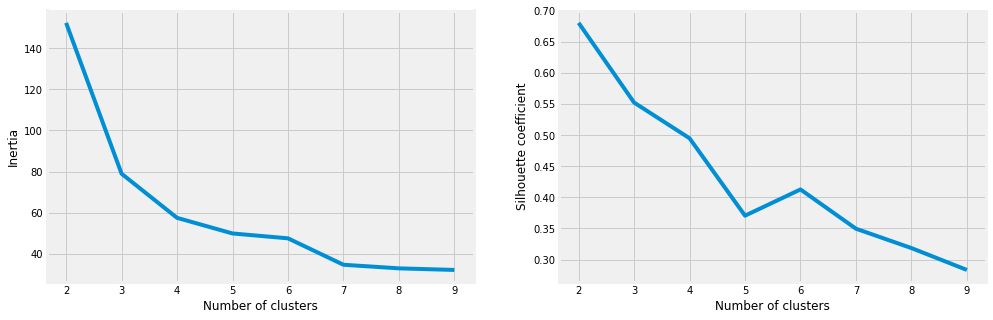

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
k_clusters = range(2,10)

ax1.plot(k_clusters, sses)
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia');

ax2.plot(k_clusters, sils)
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette coefficient')

Looks as if the K = 3 clusters seems appropriate -- and of course there are only 3 labels in the actual data!

In [7]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

Now, let's look deeper at our model for K = 3 clusters:

In [8]:
lbl, cent = my_K_Means(X, 3, .0001)

In [9]:
cent # centroid locations

array([[5.006     , 3.418     , 1.464     , 0.244     ],
       [6.85384615, 3.07692308, 5.71538462, 2.05384615],
       [5.88360656, 2.74098361, 4.38852459, 1.43442623]])

In [10]:
lbl # clusters for each point

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2])

Let's compare to scikit-learn as well:

In [11]:
from sklearn.cluster import KMeans

In [12]:
kmeans = KMeans(n_clusters=3).fit(X)

In [13]:
kmeans.cluster_centers_ # centroid locations

array([[6.85      , 3.07368421, 5.74210526, 2.07105263],
       [5.006     , 3.418     , 1.464     , 0.244     ],
       [5.9016129 , 2.7483871 , 4.39354839, 1.43387097]])

In [14]:
# clusters for each point
lbl_sklearn = kmeans.labels_
lbl_sklearn

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int32)

Looks not bad -- let's just make a dictionary to match up the cluster labels using each method.

In [15]:
label_match = {0: 1, 1: 0, 2: 2}

In [16]:
lbl_sklearn_match = [label_match[k] for k in lbl_sklearn]
np.array(lbl_sklearn_match)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2])

In [17]:
# how many match between my code and scikit-learn
sum(lbl == lbl_sklearn_match) / len(lbl)

0.9933333333333333

I guess that's OK! Now let's take a look at how we performed w.r.t. the actual labels (from `y`)

In [18]:
actual_label_match = {0: 0, 1: 2, 2: 1}
y_lbl = [actual_label_match[k] for k in y]
np.array(y_lbl)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
# my_acc = np.mean(lbl == y_lbl)
my_acc = np.mean([lbl[k] == y_lbl[k] for k in range(len(lbl))])
my_acc

0.8866666666666667

In [20]:
sklearn_acc = np.mean([lbl_sklearn_match[k] == y_lbl[k] for k in range(len(y_lbl))])
# sklearn_acc = np.mean(lbl_sklearn_match == y_lbl) #why doesn't this work?
sklearn_acc

0.8933333333333333

Again, I guess that's not all that bad, and not far off from the output from scikit-learn.